<div style="background-color: #cfc ; padding: 20px; border-radius: 10px ; border: 2px solid green;">
<p><font size="+3"><b><center> ICLR Submission </center></b></font>
</p>
<p>
<font size="+3">  <b> <center> (Quantum) Orthogonal Neural Network </center></b></font>
</p>    
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import time
import os.path
import warnings
warnings.filterwarnings('ignore')

import quantum_ortho_nn, classical_ortho_nn, classical_fnn
from data_loader import load_data

## Simulation Function
A single function to run for each dataset and configuration. It trains 3 neural networks (quantum orthogonal, classical, and classical orthogonal), save and plot the training & testing learning curves. 

Parameters:
- `dataset_name` *(e.g. 'MNIST', 'oct', 'breast', 'pneumonia' )*
- `layer_architecture` *(e.g. [16,8,10] )* Note: the 1st value defines the dimensionality reduction. The last defines the number of classes!
- `dim_reduction_technique` *('PCA' or 'average', default:'PCA')*
- `normalisation` *(default: False)*
- `train_size` 
- `test_size` 
- `num_epochs` *(default: 50)*
- `mini_batch_size` *(default: 5)*
- `learning_rate` *(default: 0.5)*
- `method` *(`'LOAD'` (default) if we want to load previous results, '`TRAIN'` if we want to train the networks from scratch)*
- `return_` *(`'False'` by default, otherwise with `True` it returns the values of the train/test accuracies)*

In [4]:
def Simulation(dataset_name,
               layer_architecture,
               train_size,
               test_size,
               classes=[0,1],
               balanced_training=False,
               balanced_testing=False,
               normalisation=False,
               dim_reduction_technique='PCA',
               num_epochs=50,
               mini_batch_size=5,
               learning_rate=0.5,
               method='LOAD',
               return_=False):
    
    # PATH for saving/loading files
    if normalisation:
        path = "Simulations_results_OrthoNN/"+dataset_name+'_'+"normalised"+'_'+dim_reduction_technique+'_'+str(layer_architecture)[1:-1].replace(', ','-')+'_'+'train-'+str(train_size)+'_test-'+str(test_size)+'__'        
    else:
        path = "Simulations_results_OrthoNN/"+dataset_name+'_'+dim_reduction_technique+'_'+str(layer_architecture)[1:-1].replace(', ','-')+'_'+'train-'+str(train_size)+'_test-'+str(test_size)+'__'
    
    # LOAD PREVIOUS RESULTS OR LAUNCH TRAINING
    if method=='LOAD': #results saved before
        if not os.path.isfile(path+'results.npy'): #but verify there's something
            print("NO FILES SAVED!")
            method = 'TRAIN'
        else:
            print("Loading Previous Results")
            q_result_train, q_result_test, c_result_train ,c_result_test ,s_result_train ,s_result_test = np.load(path+'results.npy')
    
    
    if method=="TRAIN": # RUN THE 3 TRAININGS
        print("TRAINING") 
        
        start = time.time()
        
        #define the 3 networks: quantum orthogonal, classical, and classical orthogonal 
        print('\tinit neural nets..')
        net_quantum = quantum_ortho_nn.Network(layer_architecture, cost=quantum_ortho_nn.QuadraticCost)
        net_classical = classical_fnn.Network(layer_architecture, cost=classical_fnn.QuadraticCost)
        net_classical_svd = classical_ortho_nn.Network(layer_architecture, cost=classical_ortho_nn.QuadraticCost)
        
        print('Loading data...')
        dim_scale = layer_architecture[0]
        
        n_classes = len(classes)

        training_data, _, _ = load_data(dataset=dataset_name,
                                       balanced=balanced_training,
                                       classes=classes,
                                       samples=[train_size, 0, 0],
                                       dim_scale=dim_scale,
                                       dim_red_method=dim_reduction_technique)
        
        _, test_data, _ = load_data(dataset=dataset_name,
                                       balanced=balanced_testing,
                                       classes=classes,
                                       samples=[0, test_size, 0],
                                       dim_scale=dim_scale,
                                       dim_red_method=dim_reduction_technique)

        #NORMALISE LOADED DATA
        if normalisation == True:
            training_data[:][0] = [x/np.linalg.norm(x) for x in training_data[:][0]]
            test_data[:][0] = [x/np.linalg.norm(x) for x in test_data[:][0]]
                
        #TRAINING
        print('\n\nClassical (Not Orthogonal)')
        _, test_accuracy_C, _, training_accuracy_C = net_classical.SGD(training_data, num_epochs, mini_batch_size, learning_rate, lmbda = 0, evaluation_data=test_data, print_during_training=False)
        print('\n\nClassical (SVB Orthogonal)')
        _, test_accuracy_Csvd, _, training_accuracy_Csvd = net_classical_svd.SGD(training_data, num_epochs, mini_batch_size, learning_rate, lmbda = 0, evaluation_data=test_data, print_during_training=False)
        print('\nPyramidal Orthogonal (Quantum)')
        _, test_accuracy_Q, _, training_accuracy_Q = net_quantum.SGD(training_data, num_epochs, mini_batch_size, learning_rate, lmbda = 0, evaluation_data=test_data, print_during_training=False)
        #results
        q_result_train = np.array(training_accuracy_Q)*100/(train_size*n_classes)
        q_result_test = np.array(test_accuracy_Q)*100/(test_size*n_classes)
        c_result_train = np.array(training_accuracy_C)*100/(train_size*n_classes)
        c_result_test = np.array(test_accuracy_C)*100/(test_size*n_classes)
        s_result_train = np.array(training_accuracy_Csvd)*100/(train_size*n_classes)
        s_result_test = np.array(test_accuracy_Csvd)*100/(test_size*n_classes)
        #save results
        np.save(path+'results.npy',[q_result_train, q_result_test, c_result_train, c_result_test, s_result_train, s_result_test])
        print('\n\ntotal training time:',np.round(time.time()-start,3),'s')

    
    ## PLOT RESULTS
    #sizes
    plt.figure(figsize=(10,8))
    linewidth=2
    fontsize=20
    fontsize_lgd=15
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    #legend for quantum vs classical
    Type = [Line2D([0], [0], color='r', lw=linewidth),
            Line2D([0], [0], color='g', lw=linewidth),
            Line2D([0], [0], color='b', lw=linewidth)]
    legend1 = plt.legend(Type,['Pyramidal Orthogonal (Quantum)', 'Classical (Not Orthogonal)', 'Classical (SVB Orthogonal)'],
              bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,fontsize=fontsize_lgd)

    #legend for train vs test
    Set = [Line2D([0], [0], color='black', linestyle='-', lw=linewidth),
           Line2D([0], [0], color='black', linestyle='--', lw=linewidth)]
    legend2 = plt.legend(Set,['Train Set', 'Test Set'],
              bbox_to_anchor=(1.05, 0.8), loc='upper left', borderaxespad=0.,fontsize=fontsize_lgd)

    #legend for neural net parameters
    neural_net_size = 'Neural Net size: '+str(layer_architecture)
    Train_Test_size = 'Train data: '+str(train_size)+' | Test data: '+str(test_size)
    Normalisation = 'Normalisation: '+str(normalisation)
    Dataset_ = 'Dataset: '+dataset_name
    Dimension = 'Dimension: '+str(layer_architecture[0])+' ('+dim_reduction_technique+')'
    Classes = 'Classes: '+str(layer_architecture[-1])
    Learning_rate = 'Learning Rate: '+str(learning_rate)
    Minibatch= 'Minibatch size: '+str(mini_batch_size)
    Params=[Line2D([0], [0], color='white', marker='o', markerfacecolor='black'),
           Line2D([0], [0], color='white', marker='o', markerfacecolor='black'),
           Line2D([0], [0], color='white', marker='o', markerfacecolor='black'),
           Line2D([0], [0], color='white', marker='o', markerfacecolor='black'),
           Line2D([0], [0], color='white', marker='o', markerfacecolor='black'),
           Line2D([0], [0], color='white', marker='o', markerfacecolor='black'),
           Line2D([0], [0], color='white', marker='o', markerfacecolor='black'),
           Line2D([0], [0], color='white', marker='o', markerfacecolor='black')]
    legend3 = plt.legend(Params,[Dataset_, Dimension, Classes, Normalisation, neural_net_size, Train_Test_size, Learning_rate,Minibatch],
              bbox_to_anchor=(1.05, 0.65), loc='upper left', borderaxespad=0.,fontsize=fontsize_lgd)

    #legend plot
    plt.gca().add_artist(legend1)
    plt.gca().add_artist(legend2)
    plt.gca().add_artist(legend3)

    #Plot!
    #quantum
    plt.plot(q_result_train,'r')
    plt.plot(q_result_test,'r--')
    #classical fnn
    plt.plot(c_result_train,'g')
    plt.plot(c_result_test,'g--')
    #classical_svd
    plt.plot(s_result_train,'b')
    plt.plot(s_result_test,'b--')

    #Misc
    plt.grid(alpha=0.3)
    plt.ylim(0,100)
    plt.title('Learning Curves',fontsize=fontsize)
    plt.ylabel('Accuracy (%)',fontsize=fontsize)
    plt.xlabel('Epoch',fontsize=fontsize)

    #Save
    plt.savefig(path+'PLOT.png',bbox_inches='tight')
    
    if return_ == True:
        return q_result_train, q_result_test, c_result_train, c_result_test, s_result_train, s_result_test
    

<div style="background-color: #cfc ; padding: 8px; border-radius: 8px ; border: 1px solid green;">
<font size="+1"><b> MNIST </b></font>
</div>

TRAINING
	init neural nets..
Loading data...


Classical
	Accuracy on training data: 1000 / 4000
	Accuracy on test data: 100 / 400
Epoch 0 training complete
Accuracy on training data: 3774 / 4000
Accuracy on test data: 356 / 400
Epoch 1 training complete
Accuracy on training data: 3803 / 4000
Accuracy on test data: 358 / 400
Epoch 2 training complete
Accuracy on training data: 3821 / 4000
Accuracy on test data: 367 / 400
Epoch 3 training complete
Accuracy on training data: 3824 / 4000
Accuracy on test data: 369 / 400
Epoch 4 training complete
Accuracy on training data: 3828 / 4000
Accuracy on test data: 368 / 400
Epoch 5 training complete
Accuracy on training data: 3846 / 4000
Accuracy on test data: 371 / 400
Epoch 6 training complete
Accuracy on training data: 3848 / 4000
Accuracy on test data: 369 / 400
Epoch 7 training complete
Accuracy on training data: 3851 / 4000
Accuracy on test data: 373 / 400
Epoch 8 training complete
Accuracy on training data: 3861 / 4000
Accuracy on test dat

Epoch 20 training complete
	Accuracy on training data: 3309 / 4000
	Accuracy on test data: 316 / 400
Epoch 21 training complete
	Accuracy on training data: 3402 / 4000
	Accuracy on test data: 333 / 400
Epoch 22 training complete
	Accuracy on training data: 3617 / 4000
	Accuracy on test data: 333 / 400
Epoch 23 training complete
	Accuracy on training data: 3418 / 4000
	Accuracy on test data: 330 / 400
Epoch 24 training complete
	Accuracy on training data: 3712 / 4000
	Accuracy on test data: 363 / 400
Epoch 25 training complete
	Accuracy on training data: 3600 / 4000
	Accuracy on test data: 348 / 400
Epoch 26 training complete
	Accuracy on training data: 3554 / 4000
	Accuracy on test data: 344 / 400
Epoch 27 training complete
	Accuracy on training data: 3688 / 4000
	Accuracy on test data: 345 / 400
Epoch 28 training complete
	Accuracy on training data: 3646 / 4000
	Accuracy on test data: 359 / 400
Epoch 29 training complete
	Accuracy on training data: 3651 / 4000
	Accuracy on test data: 

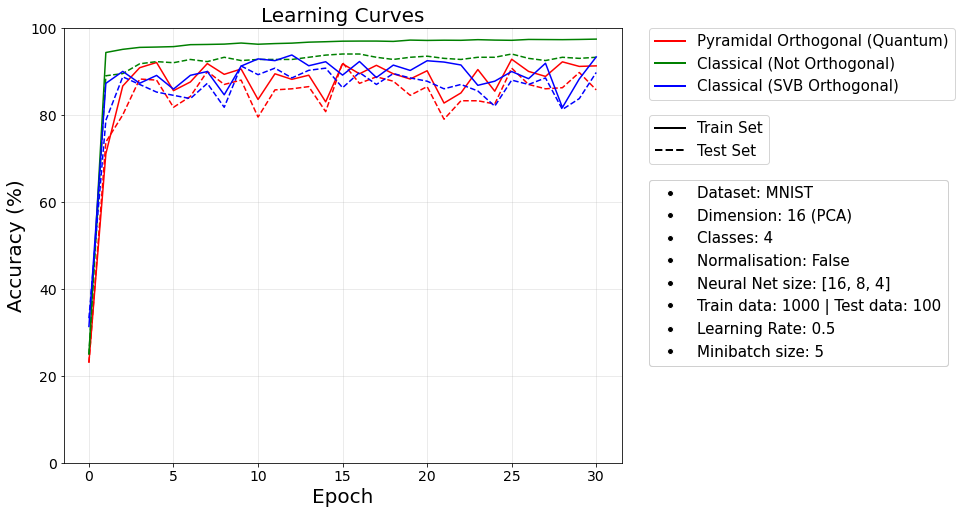

In [3]:
Simulation(dataset_name='MNIST',
           layer_architecture=[16,8,4],
           classes=[0,1,2,3],
           train_size=1000,
           test_size=100,
           balanced_training=True,
           balanced_testing=True,
           dim_reduction_technique='PCA',
           num_epochs=30,
           mini_batch_size=5,
           learning_rate=0.5,
           method='TRAIN',
           return_=False)